In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold
from sklearn.cross_validation import KFold, cross_val_score,train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25)
import itertools
%matplotlib inline
from sklearn.externals import joblib
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils import shuffle

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
import xgboost as xgb

#特征选择
from sklearn.feature_selection import RFE

/home/zhh/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1 、导入数据

In [2]:
# 读取训练集
train = pd.read_pickle("/home/zhh/文档/阿里巴巴/data/6.合表/训练集总表v3.pickle")
train = train.drop(['上中下旬','个人编码'],axis=1)
train["一次性医用材料申报金额"]=train.fillna(train["一次性医用材料申报金额"].median())

delete_list = ['药品费申报金额', '一次性医用材料申报金额','检查费申报金额',
                '治疗费申报金额','基本医疗保险统筹基金支付金额','三目项目总价',
                 '偏瘫次数和','心脏病次数和','肺心病次数和',
                 '交易间隔最大值','医院个数']
train = train.drop(delete_list,axis=1)

train.to_pickle("/home/zhh/文档/阿里巴巴/data/6.合表/训练集总表08131042.pickle")
train = pd.read_pickle("/home/zhh/文档/阿里巴巴/data/6.合表/训练集总表08131042.pickle")
train.columns
X = train.drop(["标签"],axis = 1)
y = train["标签"]

In [3]:
#************统计正负样本比例的大小**********************
y.value_counts()

0    15171
1      789
Name: 标签, dtype: int64

# 2、抽样

In [4]:
#**************抽样，以1：13的比例进行抽样*********************
rus = RandomUnderSampler(ratio={0:789*9,1:789})
X_res,y_res = rus.fit_sample(X,y)
print("***********抽样后比例*****************")
print(Counter(y_res))

X_res = pd.DataFrame(X_res,columns = X.columns)
y_res = pd.DataFrame(y_res,columns = ["标签"])

data_res = pd.concat([X_res,y_res],axis=1)
data_res = data_res.sample(frac=1)

X_res = data_res.drop(["标签"],axis=1)
y_res = data_res["标签"]

***********抽样后比例*****************
Counter({0: 7101, 1: 789})


In [5]:
#**********************10折交叉验证*******************************
#10折交叉验证
clf = RandomForestClassifier()
k_fold = KFold(len(y_res), n_folds=5, shuffle=True, random_state=42)   
f1_scores = cross_val_score(clf, X_res, y_res, cv=k_fold, n_jobs=1,scoring='f1')
f1_scores.mean()  

0.43508459386681764

# 3 、研究一下抽样对应的f1变化

CPU times: user 4min 57s, sys: 52 ms, total: 4min 57s
Wall time: 4min 57s


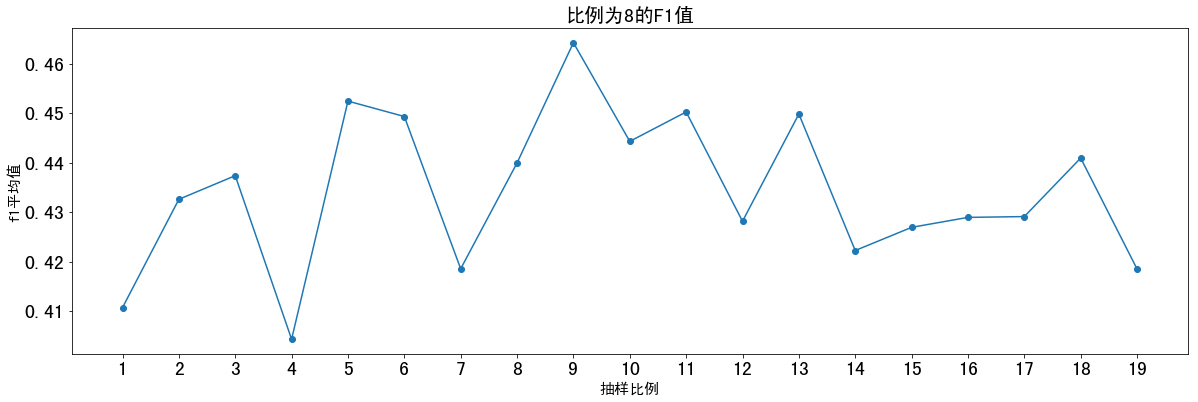

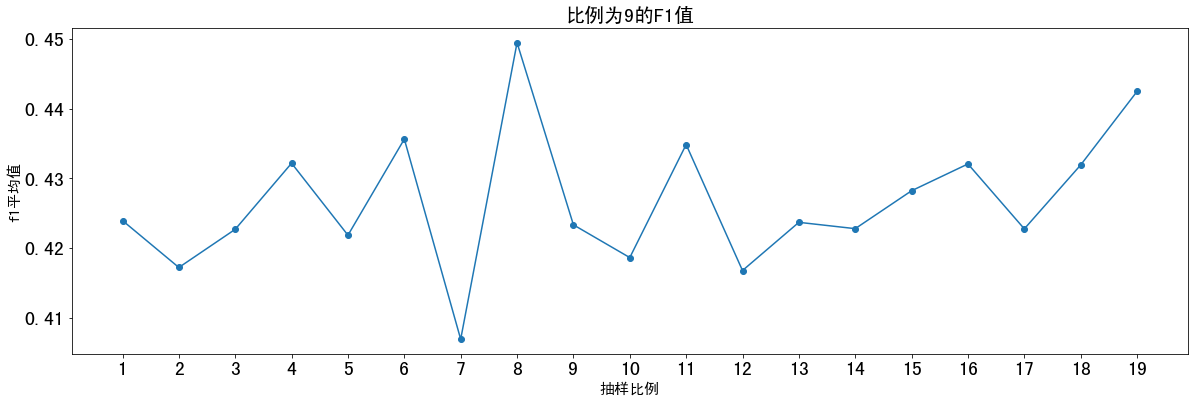

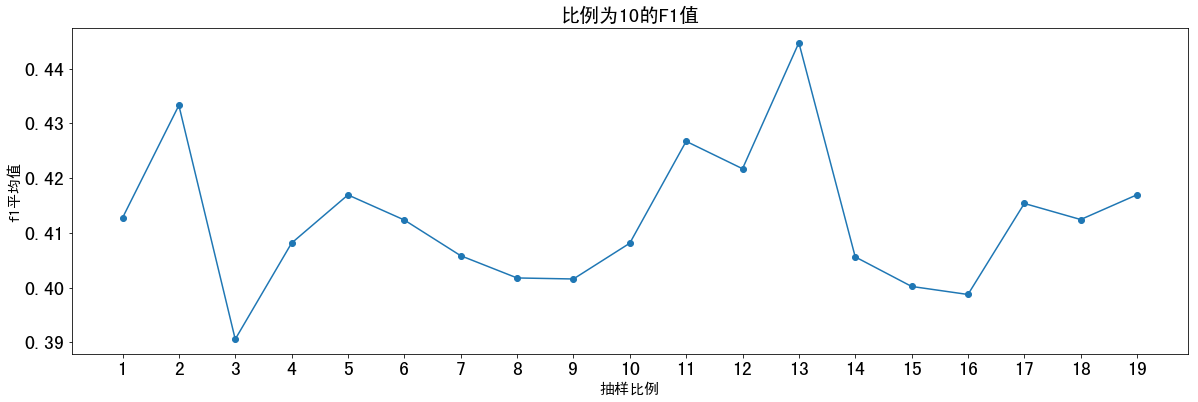

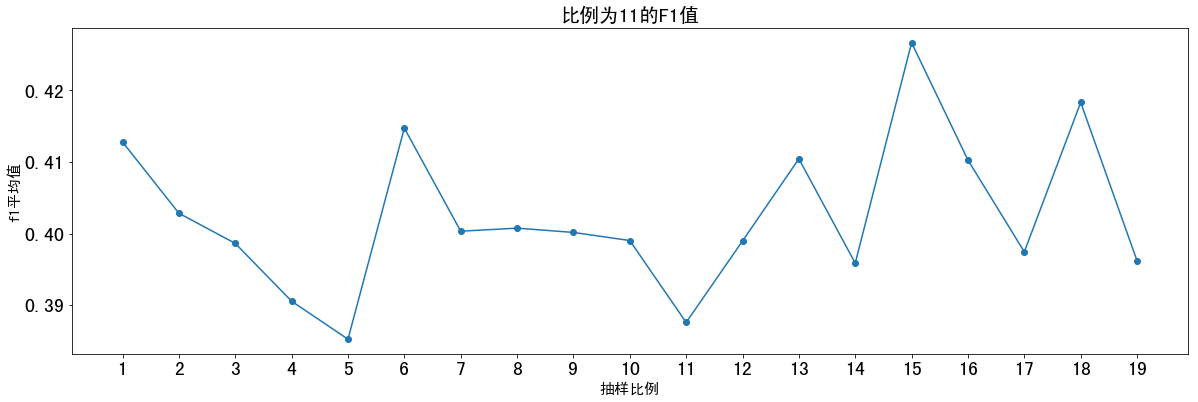

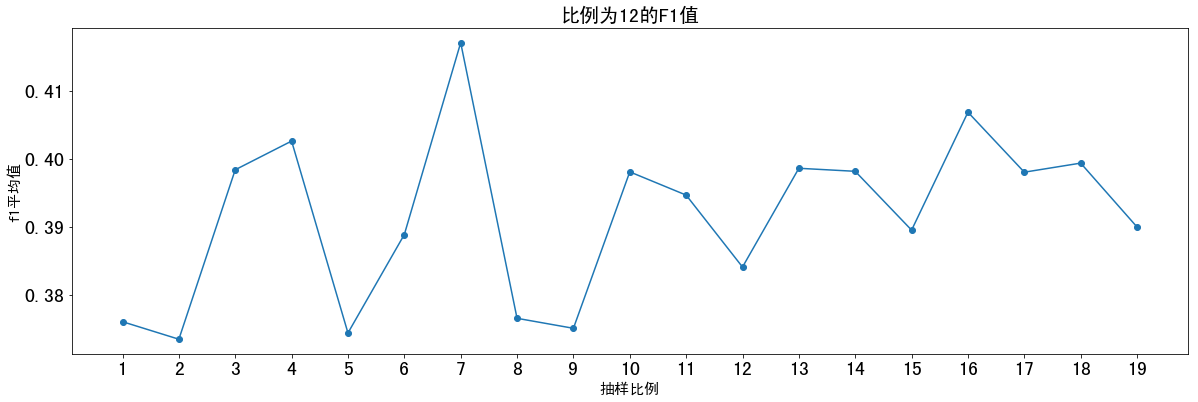

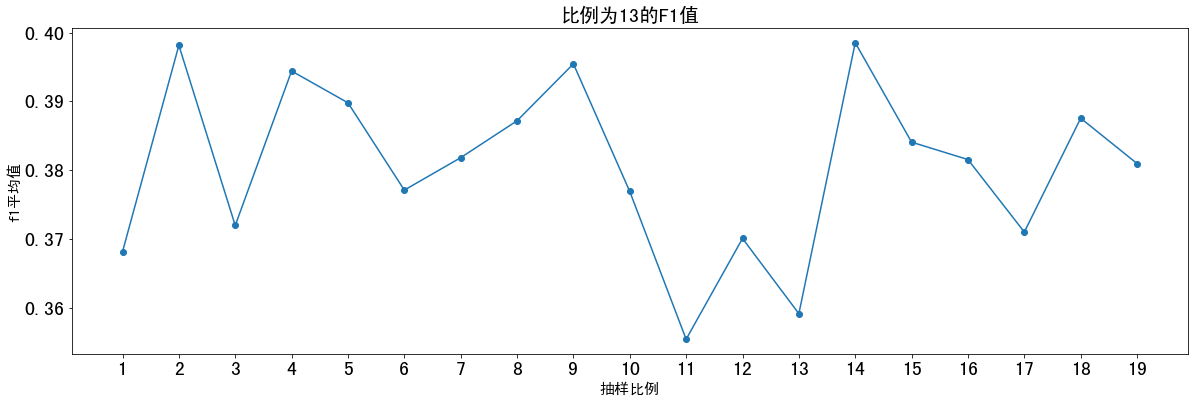

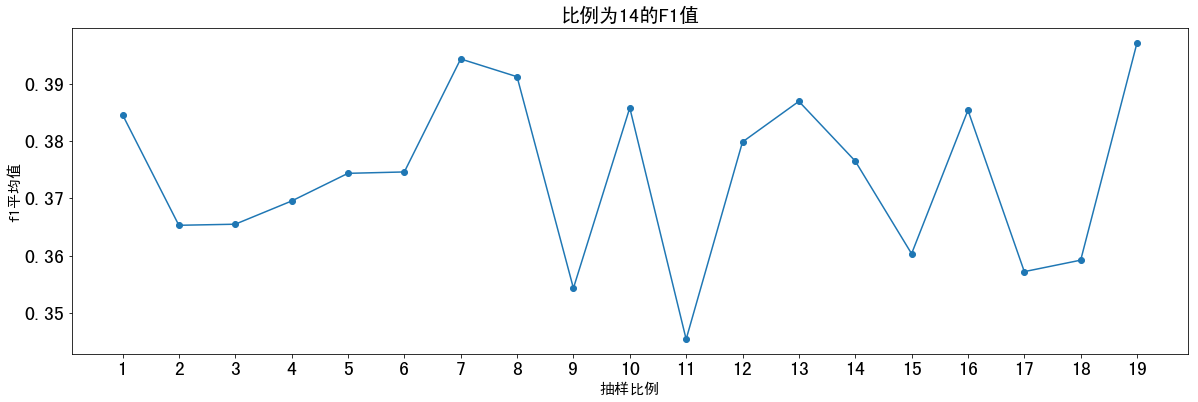

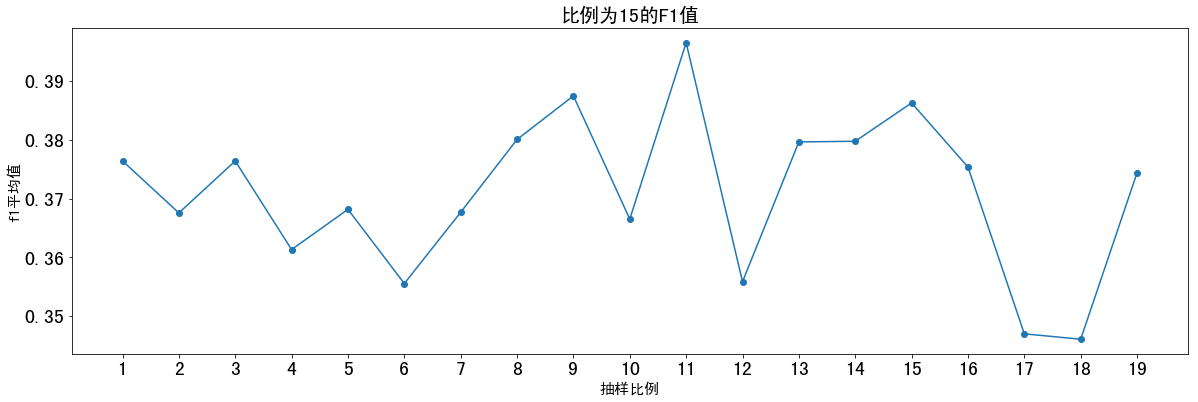

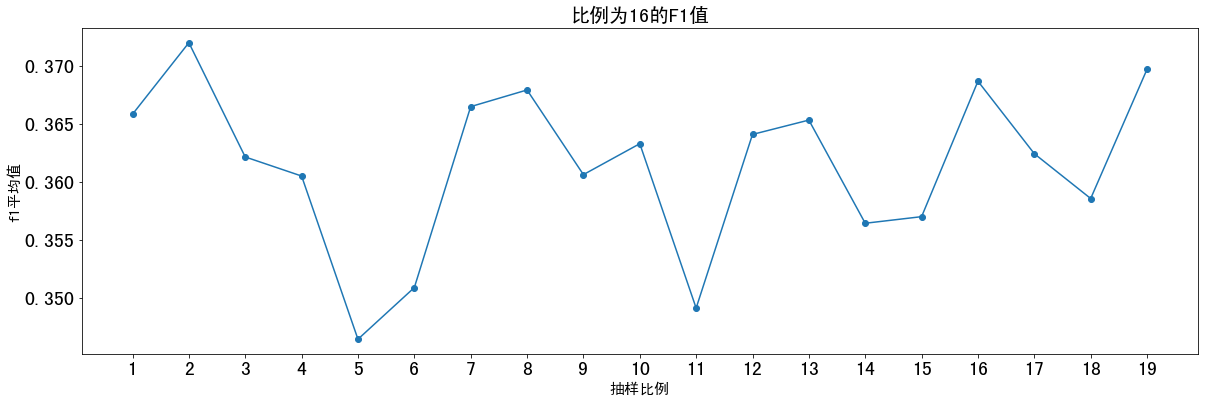

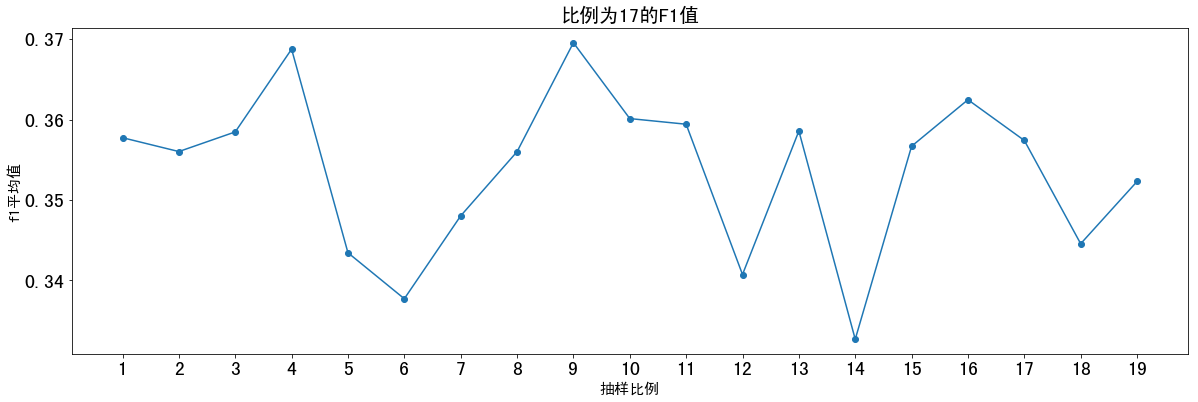

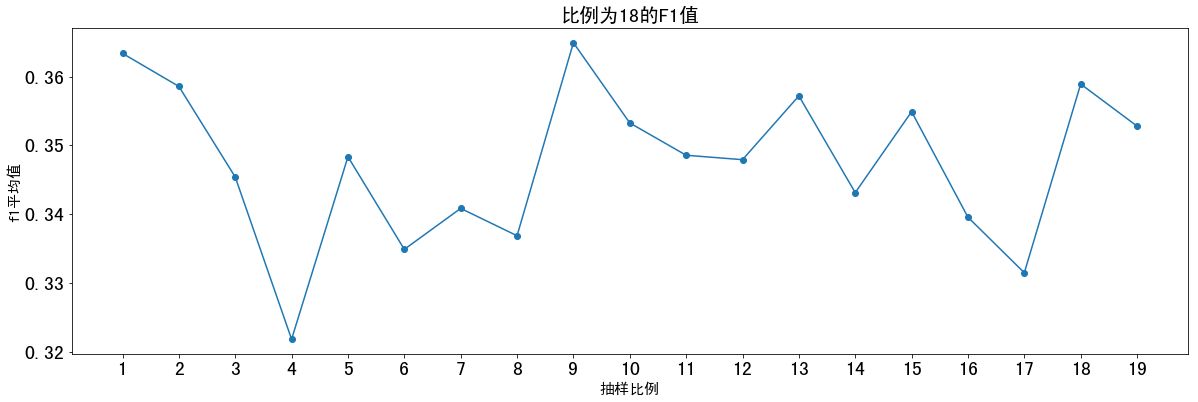

In [178]:
%%time

for i in range(8,19):
    a = []
    for num in range(1,20):
    #**************抽样，以1：13的比例进行抽样*********************
        rus = RandomUnderSampler(ratio={0:789*i,1:789})
        X_res,y_res = rus.fit_sample(X,y)
        #print("***********抽样后比例*****************")
        #print(Counter(y_res))

        X_res = pd.DataFrame(X_res,columns = X.columns)
        y_res = pd.DataFrame(y_res,columns = ["标签"])

        data_res = pd.concat([X_res,y_res],axis=1)
        data_res = data_res.sample(frac=1)

        X_res = data_res.drop(["标签"],axis=1)
        y_res = data_res["标签"]

        clf = RandomForestClassifier()
        k_fold = KFold(len(y_res), n_folds=5, shuffle=True)   
        f1_scores = cross_val_score(clf, X_res, y_res, cv=k_fold, n_jobs=1,scoring='f1')
        a.append([num,f1_scores.mean()]) 
    a = pd.DataFrame(a,columns=["比例","f1平均值"])


    fig ,ax = plt.subplots(figsize=(20,6))
    ax.plot(a.ix[:,0],a.ix[:,1],'-o')
    ax.set_title(label= '比例为{0}的F1值'.format(i),fontsize=20)
    ax.set_xlabel("抽样比例",fontsize=15)
    ax.set_ylabel("f1平均值",fontsize=15)
    plt.xticks([i for i in range(1,20)])
    #ax.set_xticklabels([i for i in range(1,20)])
    ax.tick_params(labelsize=20)

# 4、画学习曲线图

In [7]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
   
    plt.figure(figsize =(20,10) )
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring='f1')
    #print(train_scores,test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    return estimator

KeyboardInterrupt: 

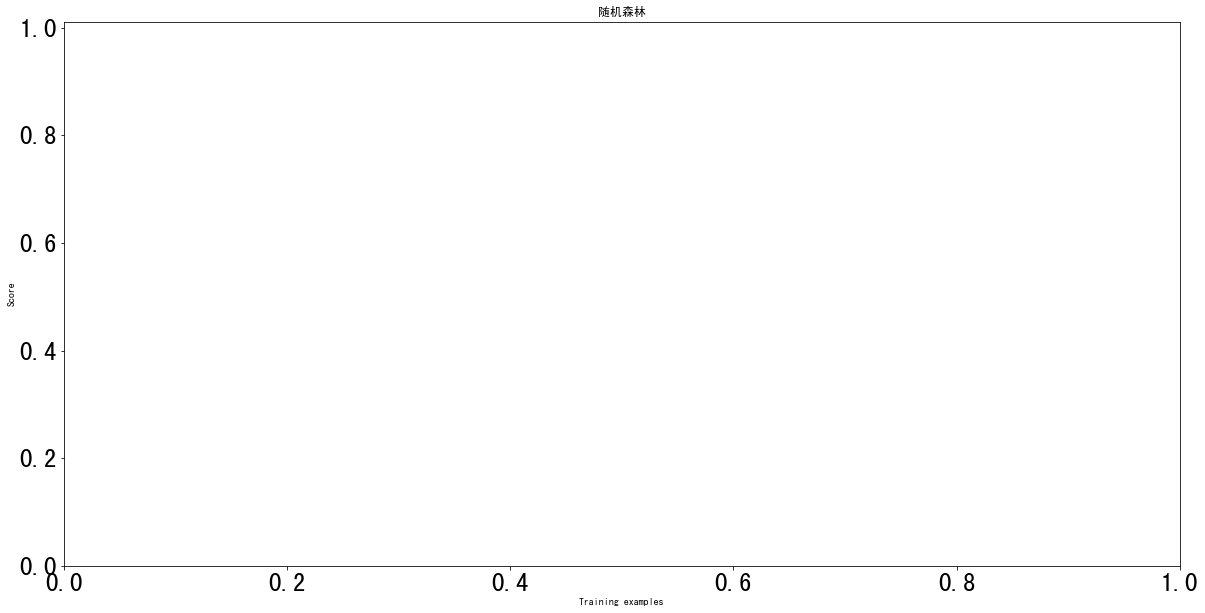

In [201]:
#lr = LogisticRegression()
#svc = SVC()
rf = RandomForestClassifier()
#estimators = [["lf",lr],["svc",svc],["rf",rf]]
cv =  StratifiedKFold(n_splits=100, shuffle=True)
plot_learning_curve(rf,'随机森林', X_res,y_res,ylim=(0.0, 1.01), cv=cv, n_jobs=4)

 # 4、 特征抽取

In [9]:
def plot_feature_import(clf,X_train):
    a = []
    for i,j in enumerate(clf.feature_importances_):
        a.append([X_train.columns.tolist()[i],j])

    # 特征和重要型
    a = pd.DataFrame(a,columns=['特征','重要性'])

    # 画图
    fig,ax = plt.subplots(figsize = (50,30))
    a.set_index('特征').sort_values('重要性',ascending=False).plot(kind = 'bar',ax=ax)
    fet_ipt = a.set_index('特征').sort_values('重要性',ascending=False)
    fet_ipt.reset_index(inplace =True)
    plt.xticks(rotation=90)
    ax.tick_params(labelsize=40)
    return fet_ipt
    plt.show()

             precision    recall  f1-score   support

          0       0.93      0.99      0.96      2128
          1       0.78      0.28      0.42       239

avg / total       0.91      0.92      0.90      2367



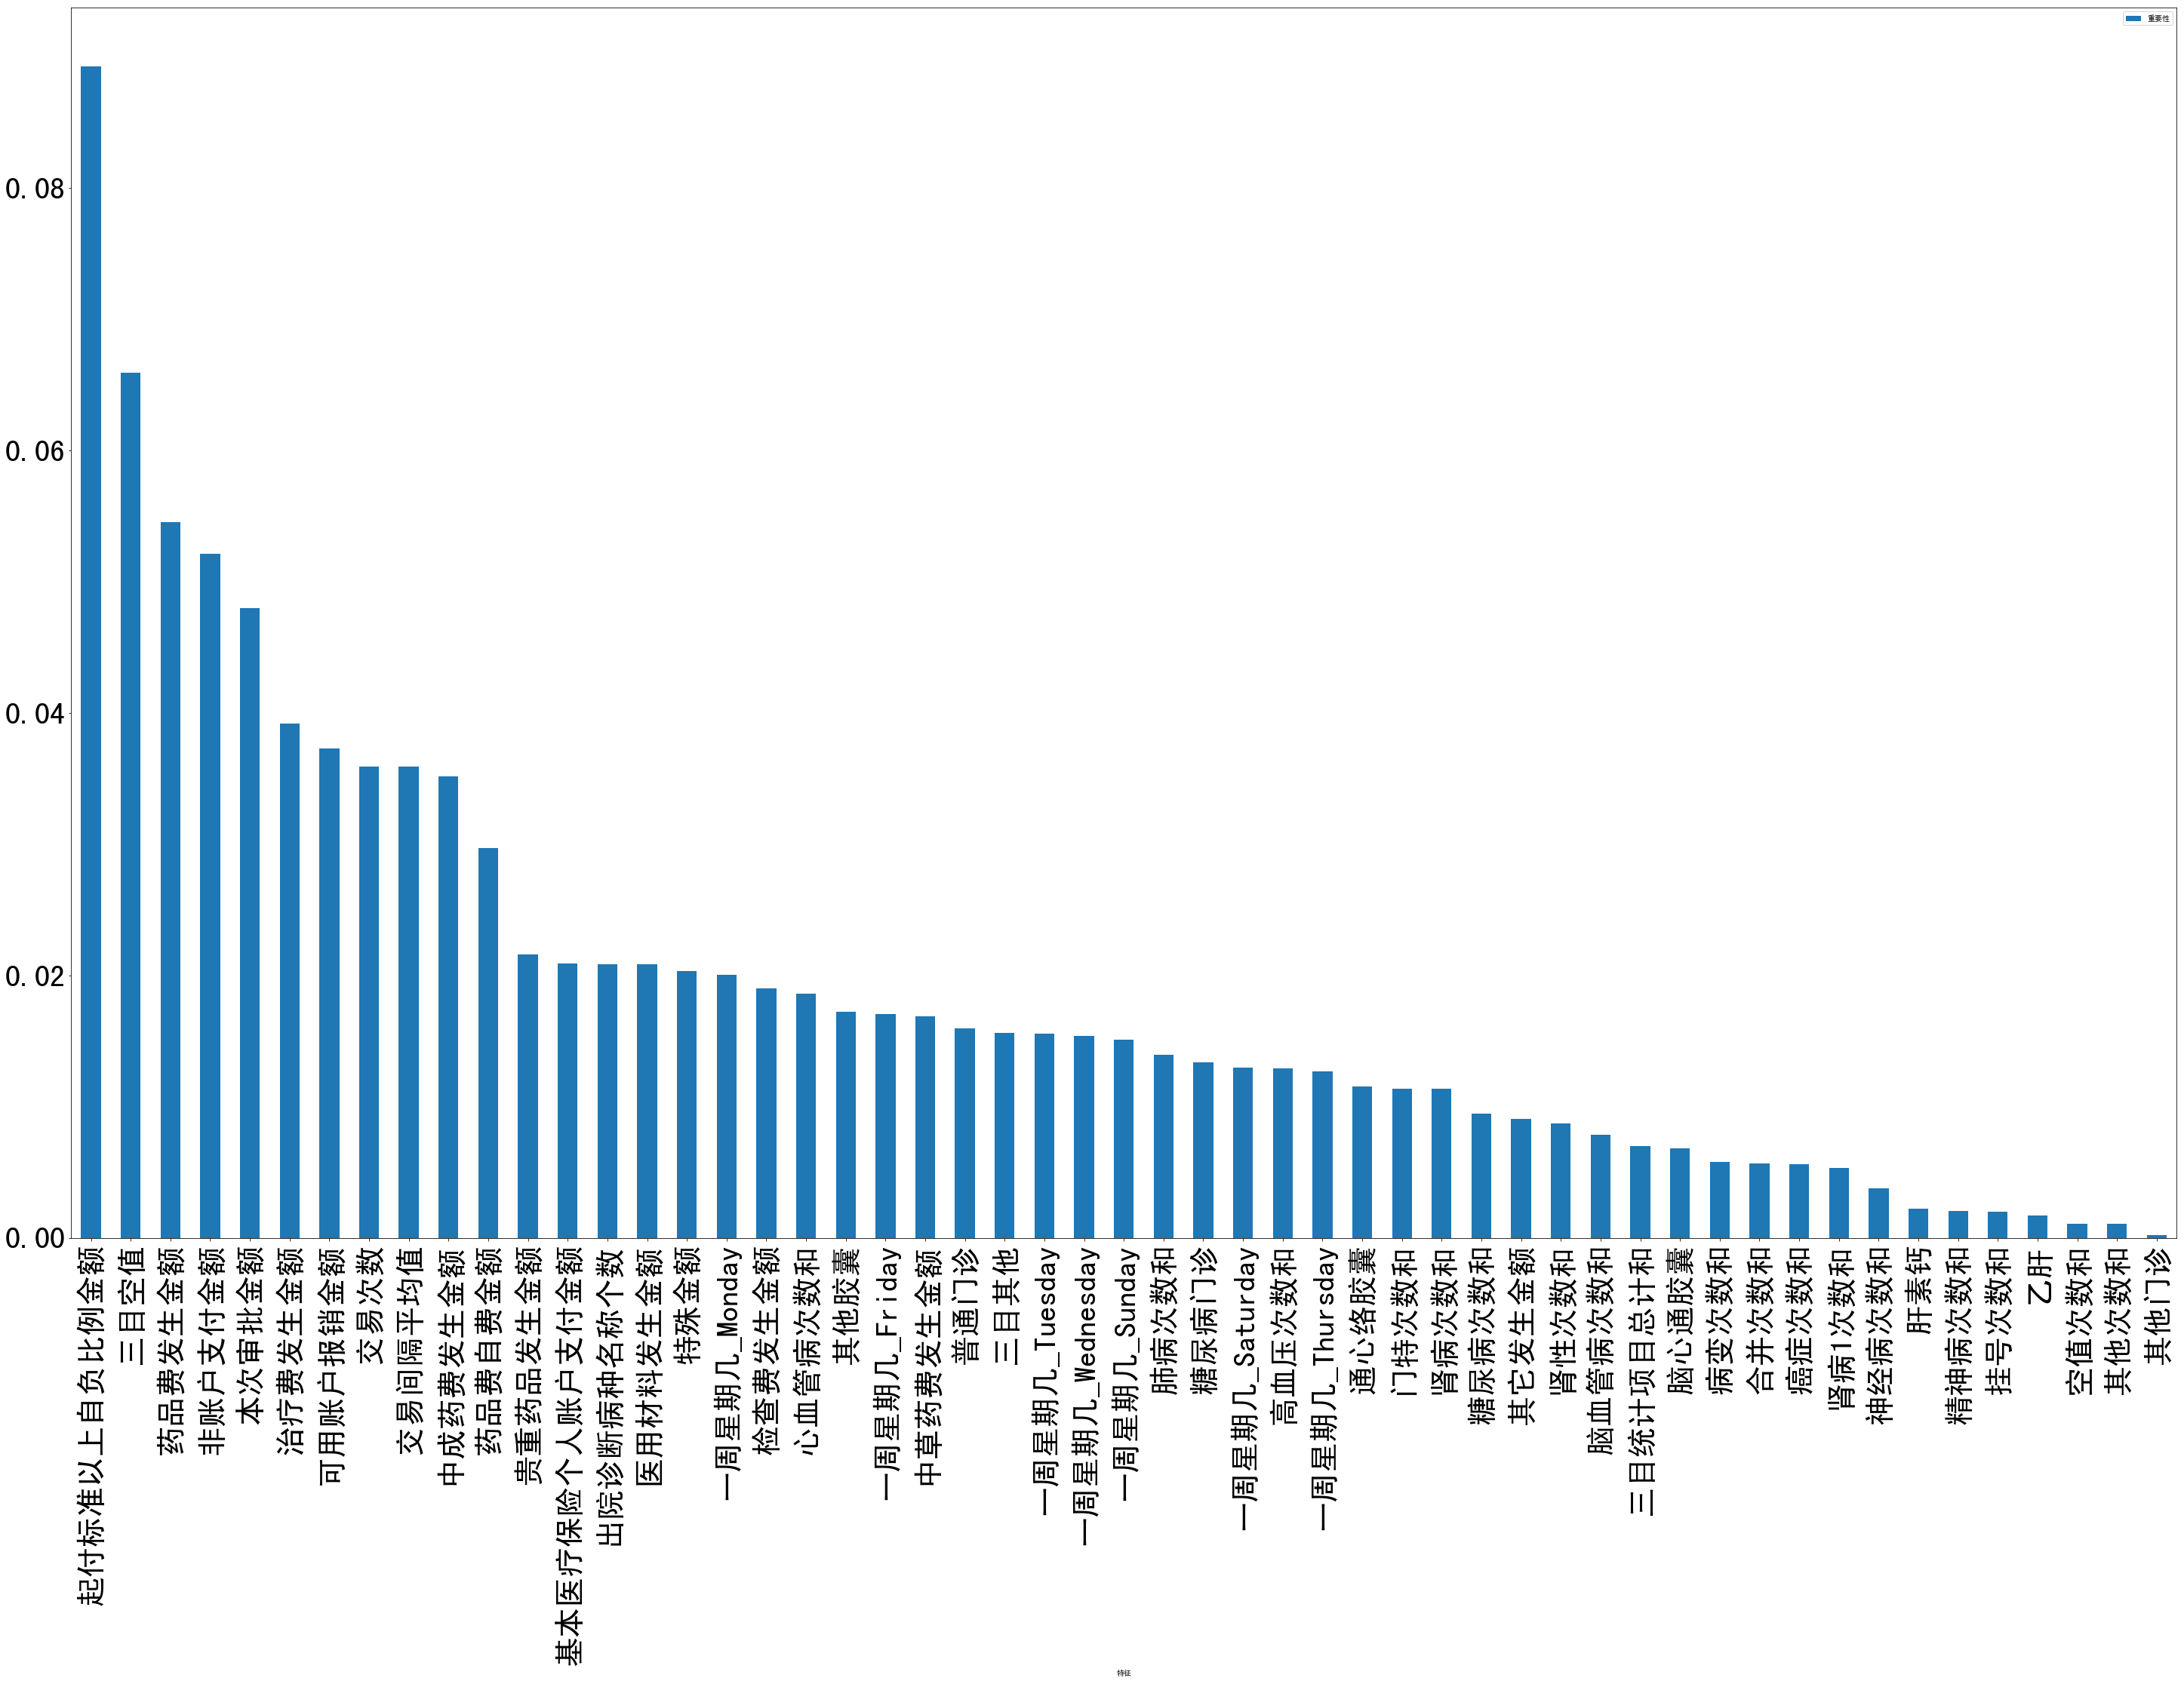

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,test_size = 0.3,random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
pred1 = clf.predict(X_test)
print(classification_report(y_test,pred1))
fet_ipt = plot_feature_import(clf,X_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

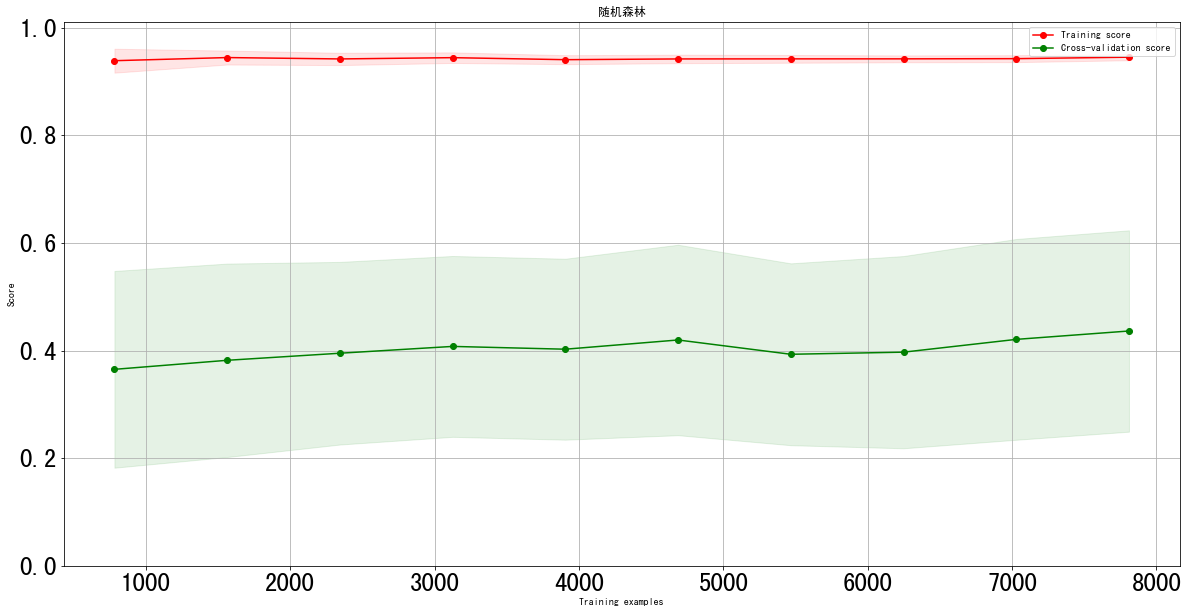

In [203]:
#lr = LogisticRegression()
#svc = SVC()
rf = RandomForestClassifier()
#estimators = [["lf",lr],["svc",svc],["rf",rf]]
cv =  StratifiedKFold(n_splits=100, shuffle=True)
plot_learning_curve(rf,'随机森林', X_res,y_res,ylim=(0.0, 1.01), cv=cv, n_jobs=4)

# 5、网格搜索参数

In [227]:
pipeline = Pipeline([('clf', RandomForestClassifier(oob_score =True))])
parameters = {
'clf__max_features':('sqrt','auto','log2'),
'clf__min_samples_leaf':[1,2,3],
'clf__n_estimators': (100,175,180,200,250),
'clf__max_depth': (25,26,30,34)
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3,scoring='f1')

In [228]:
grid_search.fit(X_train, y_train)
#grid_search.fit(X_train, y_train)
print(' 最佳效果:%0.3f' % grid_search.best_score_)
print(' 最优参数组合:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(' \t %s: %r' % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  8.7min finished


 最佳效果:0.457
 最优参数组合:
 	 clf__max_depth: 34
 	 clf__max_features: 'sqrt'
 	 clf__min_samples_leaf: 2
 	 clf__n_estimators: 175


In [229]:
predictions = grid_search.predict(X_test)
print(' 准确率:', accuracy_score(y_test, predictions))
print(' 混淆矩阵:', confusion_matrix(y_test, predictions))
print(' 分类报告:\t')
print(classification_report(y_test, predictions))

 准确率: 0.922264469793
 混淆矩阵: [[2105   20]
 [ 164   78]]
 分类报告:	
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      2125
          1       0.80      0.32      0.46       242

avg / total       0.91      0.92      0.91      2367



In [233]:
# 保存模型
joblib.dump(grid_search,"/home/zhh/文档/阿里巴巴/data/8.模型训练/0813随机森林已下采样.m")

['/home/zhh/文档/阿里巴巴/data/8.模型训练/0813随机森林已下采样.m']

# part 2 Xgboost

In [50]:
#*******************训练集和测试集转化成xgboost的格式**********************
#xgb矩阵赋值
xgb_test = xgb.DMatrix(X_test,label=y_test)
xgb_train = xgb.DMatrix(X_train, label=y_train)

#************************训练模型***************************************
params={
'num_class':2, # 类别数，与 multisoftmax 并用
'gamma':0.1,  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
'max_depth':5, # 构建树的深度，越大越容易过拟合
'lambda':3,  # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
'subsample':0.7, # 随机采样训练样本
'colsample_bytree':0.7, # 生成树时进行的列采样
'min_child_weight':5, 
# 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。 
'silent':0 ,#设置成1则没有运行信息输出，最好是设置为0.
'eta': 0.007, # 如同学习率
'seed':1000,
'nthread':7# cpu 线程数
#'eval_metric': 'auc'
}

plst = list(params.items())
num_rounds = 10000 # 迭代次数
watchlist = [(xgb_train, 'train'),(xgb_test, 'val')]

In [51]:
model = xgb.train(plst, xgb_train, num_rounds, watchlist,early_stopping_rounds=100)

[0]	train-merror:0.069708	val-merror:0.082805
Multiple eval metrics have been passed: 'val-merror' will be used for early stopping.

Will train until val-merror hasn't improved in 100 rounds.
[1]	train-merror:0.071338	val-merror:0.080693
[2]	train-merror:0.070795	val-merror:0.08027
[3]	train-merror:0.070433	val-merror:0.078158
[4]	train-merror:0.069708	val-merror:0.079848
[5]	train-merror:0.069165	val-merror:0.07858
[6]	train-merror:0.068984	val-merror:0.08027
[7]	train-merror:0.069346	val-merror:0.079425
[8]	train-merror:0.069346	val-merror:0.079848
[9]	train-merror:0.068984	val-merror:0.08027
[10]	train-merror:0.069165	val-merror:0.079848
[11]	train-merror:0.068984	val-merror:0.079848
[12]	train-merror:0.068984	val-merror:0.079848
[13]	train-merror:0.069165	val-merror:0.079003
[14]	train-merror:0.069527	val-merror:0.07858
[15]	train-merror:0.069708	val-merror:0.07858
[16]	train-merror:0.069165	val-merror:0.07858
[17]	train-merror:0.069527	val-merror:0.079425
[18]	train-merror:0.06970

In [52]:
#****************分类器报告*******************************
#预测
preds = model.predict(xgb_test,ntree_limit=model.best_ntree_limit)
test_true = np.array(y_test)#分类器报告
print(' 混淆矩阵:', confusion_matrix(test_true, preds))
print(' 分类报告:\t')
print(classification_report(test_true, preds))

 混淆矩阵: [[2113   15]
 [ 163   76]]
 分类报告:	
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      2128
          1       0.84      0.32      0.46       239

avg / total       0.92      0.92      0.91      2367



In [53]:
model.save_model('/home/zhh/文档/阿里巴巴/data/8.模型训练/08131523xgboostv2.model')

In [92]:
bst = xgb.Booster({'nthread':4}) #init model
bst.load_model('/home/zhh/文档/阿里巴巴/data/8.模型训练/08131523xgboostv2.model')

In [98]:
test = pd.read_pickle("/home/zhh/文档/阿里巴巴/data/7测试表合表/测试集总表v4.pickle")
person_id = test[["个人编码"]]
test = test.drop(["个人编码"],axis=1)

In [99]:
xgb_test = xgb.DMatrix(test)

In [108]:
pre_test = pd.DataFrame(bst.predict(xgb_test),columns =["标签"])

In [109]:
result = pd.concat([person_id,pre_test],axis=1)

In [117]:
result["标签"] = result["标签"].map(int)
test_id = pd.read_csv("/home/zhh/文档/阿里巴巴/data/df_id_test.csv",header=None)
test_id.columns = ['个人编码']
result_label =pd.merge(test_id,result,how='left')
result_label

,个人编码,标签
0,352120001207726,1
1,352120000183777,1
2,352120002857717,0
3,352120001492069,0
4,352120001574938,0
5,352120001114553,0
6,352121000142166,0
7,352120000447733,0
8,352120000515129,0
9,352121000391830,0


In [116]:
result_label.to_csv('/home/zhh/文档/阿里巴巴/data/提交结果201708132238.csv',sep=','
                    ,header=None,index=None)

# part3  特征选择

In [79]:
sl_rf = RandomForestClassifier()
rfe = RFE(sl_rf,n_features_to_select=20)
rfe.fit(X_train,y_train)
print("特征排名")
print(sorted(zip(map(lambda x:round(x,4),rfe.ranking_),X_train.columns)))

特征排名
[(1, '一周星期几_Friday'), (1, '一周星期几_Monday'), (1, '三目空值'), (1, '中成药费发生金额'), (1, '交易次数'), (1, '交易间隔平均值'), (1, '出院诊断病种名称个数'), (1, '医用材料发生金额'), (1, '可用账户报销金额'), (1, '基本医疗保险个人账户支付金额'), (1, '普通门诊'), (1, '本次审批金额'), (1, '检查费发生金额'), (1, '治疗费发生金额'), (1, '药品费发生金额'), (1, '药品费自费金额'), (1, '贵重药品发生金额'), (1, '起付标准以上自负比例金额'), (1, '非账户支付金额'), (1, '高血压次数和'), (2, '特殊金额'), (3, '心血管病次数和'), (4, '中草药费发生金额'), (5, '一周星期几_Saturday'), (6, '一周星期几_Wednesday'), (7, '一周星期几_Tuesday'), (8, '一周星期几_Sunday'), (9, '三目其他'), (10, '一周星期几_Thursday'), (11, '其他胶囊'), (12, '其它发生金额'), (13, '糖尿病次数和'), (14, '肾病次数和'), (15, '三目统计项目总计和'), (16, '肺病次数和'), (17, '门特次数和'), (18, '糖尿病门诊'), (19, '通心络胶囊'), (20, '脑心通胶囊'), (21, '脑血管病次数和'), (22, '合并次数和'), (23, '病变次数和'), (24, '癌症次数和'), (25, '神经病次数和'), (26, '肾性次数和'), (27, '肾病1次数和'), (28, '肝素钙'), (29, '挂号次数和'), (30, '精神病次数和'), (31, '其他次数和'), (32, '乙肝'), (33, '空值次数和'), (34, '其他门诊')]


In [80]:
se_fet_list = []
for i,j in enumerate(rfe.ranking_):
    if j ==1:
        se_fet_list.append(X_train.columns[i])

In [81]:
#****************选取特征********************************
wp_X_train = X_train[se_fet_list]
wp_X_test = X_test[se_fet_list]
wp_X_res = X_res[se_fet_list]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

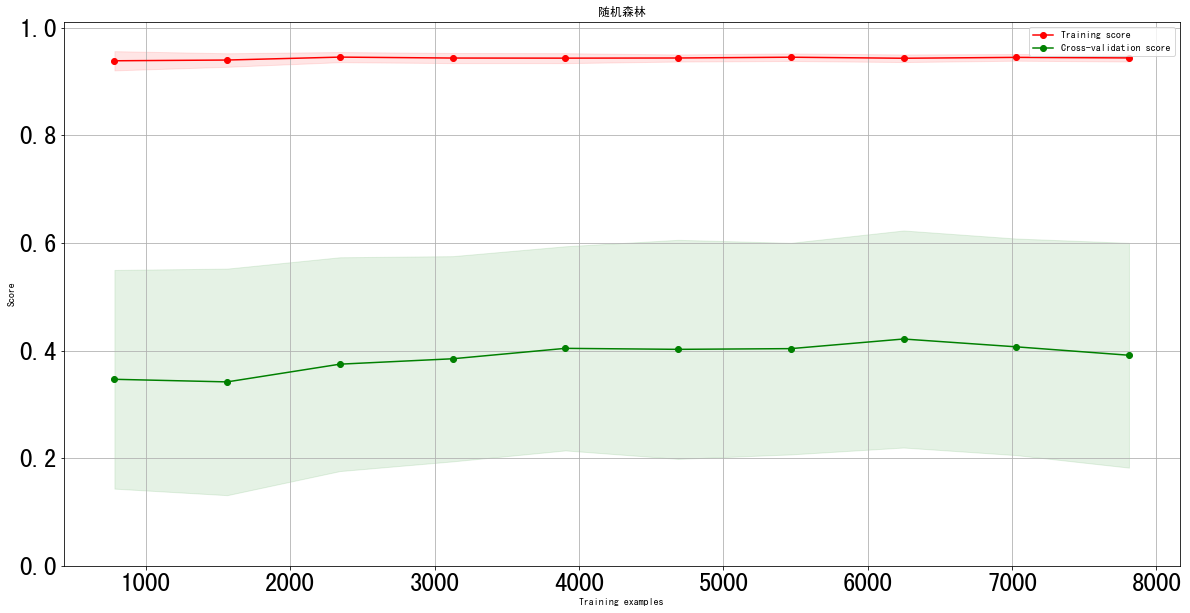

In [83]:

rf = RandomForestClassifier()
#estimators = [["lf",lr],["svc",svc],["rf",rf]]
cv =  StratifiedKFold(n_splits=100, shuffle=True)
plot_learning_curve(rf,'随机森林', wp_X_res,y_res,ylim=(0.0, 1.01), cv=cv, n_jobs=4)

In [84]:
#*******************网格搜索参数************************************************
pipeline = Pipeline([('clf', RandomForestClassifier(oob_score =True))])
parameters = {
'clf__max_features':('sqrt','auto','log2'),
'clf__min_samples_leaf':[1,2,3],
'clf__n_estimators': (100,175,180,200,250),
'clf__max_depth': (25,26,30,34)
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3,scoring='f1')

In [85]:
grid_search.fit(wp_X_train, y_train)
#grid_search.fit(X_train, y_train)
print(' 最佳效果:%0.3f' % grid_search.best_score_)
print(' 最优参数组合:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(' \t %s: %r' % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  8.3min finished


 最佳效果:0.476
 最优参数组合:
 	 clf__max_depth: 25
 	 clf__max_features: 'sqrt'
 	 clf__min_samples_leaf: 1
 	 clf__n_estimators: 175


In [86]:
predictions = grid_search.predict(wp_X_test)
print(' 准确率:', accuracy_score(y_test, predictions))
print(' 混淆矩阵:', confusion_matrix(y_test, predictions))
print(' 分类报告:\t')
print(classification_report(y_test, predictions))

 准确率: 0.926489226869
 混淆矩阵: [[2115   13]
 [ 161   78]]
 分类报告:	
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      2128
          1       0.86      0.33      0.47       239

avg / total       0.92      0.93      0.91      2367



In [88]:
joblib.dump(grid_search,"/home/zhh/文档/阿里巴巴/data/8.模型训练/0813随机森林经过wp选择.m")

['/home/zhh/文档/阿里巴巴/data/8.模型训练/0813随机森林经过wp选择.m']

 # 方差抽取

In [134]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [135]:
per_f1 = []
for percent in [10,20,30,40,50,60,70,80,90]:

    selector = SelectPercentile(f_classif,percentile= percent)
    a = selector.fit(X_train,y_train)

    #********************************8
    a = []
    for i,j in enumerate(selector.get_support()):
        if j == True:
            a.append(X_train.columns[i])
    sp_X_res = X_res[a]
    sp_X_train = X_train[a]
    sp_X_test = X_test[a]
    #*********************************************

    #**********************10折交叉验证*******************************
    #10折交叉验证
    clf = RandomForestClassifier()
    k_fold = KFold(len(y_res), n_folds=5, shuffle=True, random_state=42)   
    f1_scores = cross_val_score(clf, sp_X_res, y_res, cv=k_fold, n_jobs=1,scoring='f1')
    per_f1.append([percent,f1_scores.mean()]) 

In [136]:
# 抽取百分30%的特征
selector = SelectPercentile(f_classif,percentile = 30)
a = selector.fit(X_train,y_train)

    #********************************8
a = []
for i,j in enumerate(selector.get_support()):
    if j == True:
         a.append(X_train.columns[i])
sp_X_res = X_res[a]
sp_X_train = X_train[a]
sp_X_test = X_test[a]

In [137]:
#*******************网格搜索参数************************************************
pipeline = Pipeline([('clf', RandomForestClassifier(oob_score =True))])
parameters = {
'clf__max_features':('sqrt','auto','log2'),
'clf__min_samples_leaf':[1,2,3],
'clf__n_estimators': (100,175,180,200,250),
'clf__max_depth': (25,26,30,34)
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3,scoring='f1')

In [138]:
grid_search.fit(sp_X_train, y_train)
#grid_search.fit(X_train, y_train)
print(' 最佳效果:%0.3f' % grid_search.best_score_)
print(' 最优参数组合:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(' \t %s: %r' % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  5.5min finished


 最佳效果:0.479
 最优参数组合:
 	 clf__max_depth: 26
 	 clf__max_features: 'sqrt'
 	 clf__min_samples_leaf: 1
 	 clf__n_estimators: 100


In [139]:
predictions = grid_search.predict(sp_X_test)
print(' 准确率:', accuracy_score(y_test, predictions))
print(' 混淆矩阵:', confusion_matrix(y_test, predictions))
print(' 分类报告:\t')
print(classification_report(y_test, predictions))

 准确率: 0.923531896916
 混淆矩阵: [[2108   20]
 [ 161   78]]
 分类报告:	
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      2128
          1       0.80      0.33      0.46       239

avg / total       0.92      0.92      0.91      2367



In [140]:
joblib.dump(grid_search,"/home/zhh/文档/阿里巴巴/data/8.模型训练/0813随机森林经过方差选择.m")

['/home/zhh/文档/阿里巴巴/data/8.模型训练/0813随机森林经过方差选择.m']

# part 4 将已经log后的数据全部恢复

In [23]:
fee_columns = []
for i in X.columns:
    if "金额" in i or "价" in i or "费" in i:
        fee_columns.append(i)

In [83]:
#**************抽样，以1：13的比例进行抽样*********************
rus = RandomUnderSampler(ratio={0:789*9,1:789})
X_res,y_res = rus.fit_sample(X,y)
print("***********抽样后比例*****************")
print(Counter(y_res))

X_res = pd.DataFrame(X_res,columns = X.columns)
y_res = pd.DataFrame(y_res,columns = ["标签"])

data_res = pd.concat([X_res,y_res],axis=1)
data_res = data_res.sample(frac=1)

X_res = data_res.drop(["标签"],axis=1)
y_res = data_res["标签"]



X_fee = np.exp(X_res[fee_columns])
jypj = np.exp(X_res[['交易间隔平均值']])
X_new = pd.concat([X_fee,jypj],axis=1)
other  = set(X.columns.tolist()) - set(fee_columns) -set(["交易间隔平均值"])
X_new  = pd.concat([X_new,X_res[list(other)]],axis=1)

X_new = np.log(X_new+0.001)

***********抽样后比例*****************
Counter({0: 7101, 1: 789})


In [84]:
new_X_train, new_X_test, y_train, y_test = train_test_split(X_new ,y_res,test_size = 0.3,random_state=42)

In [87]:
#*******************网格搜索参数************************************************
pipeline = Pipeline([('clf', RandomForestClassifier())])
parameters = {
'clf__n_estimators': (100,150,200),
'clf__max_depth': (20,25,30,35)
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3,scoring='f1')

In [88]:
grid_search.fit(new_X_train, y_train)
#grid_search.fit(X_train, y_train)
print(' 最佳效果:%0.3f' % grid_search.best_score_)
print(' 最优参数组合:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print(' \t %s: %r' % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   28.1s finished


 最佳效果:0.462
 最优参数组合:
 	 clf__max_depth: 35
 	 clf__n_estimators: 150


In [89]:
predictions = grid_search.predict(new_X_test)
print(' 准确率:', accuracy_score(y_test, predictions))
print(' 混淆矩阵:', confusion_matrix(y_test, predictions))
print(' 分类报告:\t')
print(classification_report(y_test, predictions))

 准确率: 0.929446556823
 混淆矩阵: [[2128   20]
 [ 147   72]]
 分类报告:	
             precision    recall  f1-score   support

          0       0.94      0.99      0.96      2148
          1       0.78      0.33      0.46       219

avg / total       0.92      0.93      0.92      2367

